In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipas
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import time
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask
from mpl_toolkits.mplot3d import Axes3D
from shapely.ops import nearest_points
from pyquaternion import Quaternion
import copy as cp
from scipy import spatial 
from shapely.geometry import Point
from shapely.ops import nearest_points
import pandas as pd
from dask import dataframe as dd
import pickle
import scipy.stats as st
import datetime

In [ ]:
cluster = SLURMCluster(
queue='kratos',
walltime='04-23:00:00',
cores=1,
memory='20000MiB', #1 GiB = 1,024 MiB
processes=1)

cluster.scale(28)
client = Client(cluster)
print(client)

In [ ]:
client

In [3]:
def main():
    output = np.empty((len(phioarr),len(reqarr)),dtype=object)
    for phi in range(len(phioarr)):
        for r in range(len(reqarr)):
            #output[phi,r] = dask.delayed(ipas.collect_clusters_ice_ice)(phioarr[phi], reqarr[r], nclusters, ncrystals,rand_orient)
            ipas.collect_clusters_ice_ice(phioarr[phi], reqarr[r], nclusters, ncrystals,rand_orient)
    #delayeds = client.compute(delayeds)
    #output = client.gather(delayeds)

    return output

In [4]:
def compute():
    agg_as = np.empty((len(phioarr),len(reqarr), nclusters))
    agg_bs = np.empty((len(phioarr),len(reqarr), nclusters))
    agg_cs = np.empty((len(phioarr),len(reqarr), nclusters))
    #phi2Ds = np.empty((len(phioarr),len(reqarr), nclusters))
    #cplxs = np.empty((len(phioarr),len(reqarr), nclusters))
    #dds = np.empty((len(phioarr),len(reqarr), nclusters))
    #major_ax_zs = np.empty((len(phioarr),len(reqarr), nclusters))
    #depths = np.empty((len(phioarr),len(reqarr), nclusters))

    gather = client.compute([*output.tolist()])  #only parallelizing agg r bins
    gather = client.gather(gather)

    gather = np.array(gather)
    print(np.shape(gather))
    agg_as = gather[:,:,0,:]
    agg_bs = gather[:,:,1,:]
    agg_cs = gather[:,:,2,:]
    #phi2Ds = gather[:,:,3,:]
    #cplxs = gather[:,:,4,:] 
    #dds = gather[:,:,5,:]
    #major_ax_zs = gather[:,:,6,:]
    #depths = gather[:,:,7,:]
    print('DONE!')
    return agg_as, agg_bs, agg_cs #, phi2Ds, cplxs, dds, major_ax_zs, depths

x


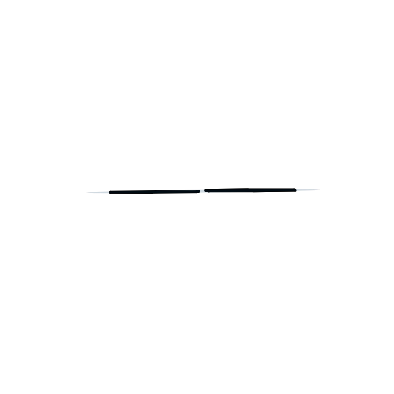

y


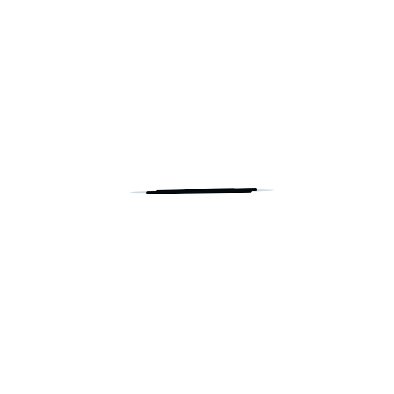

z


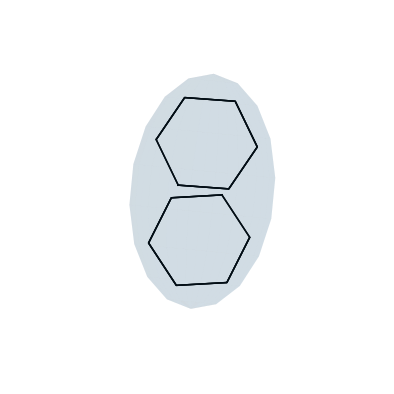

x


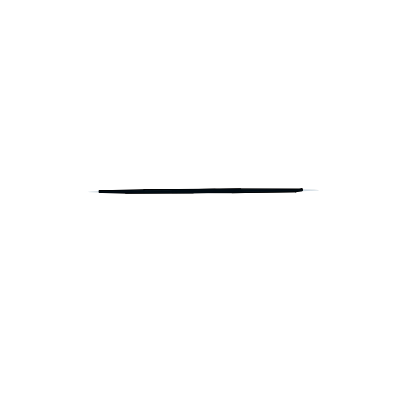

y


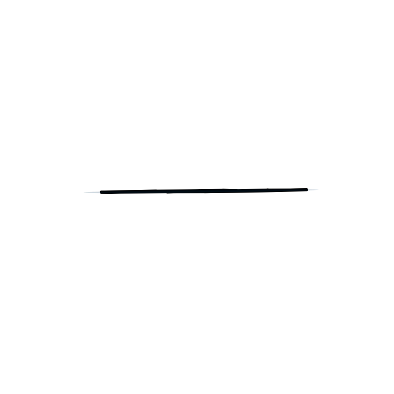

z


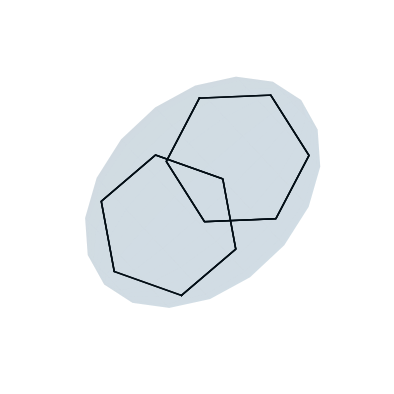

x


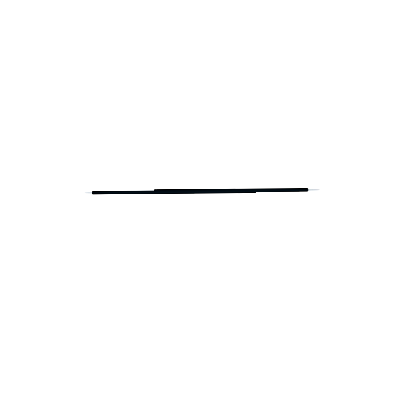

y


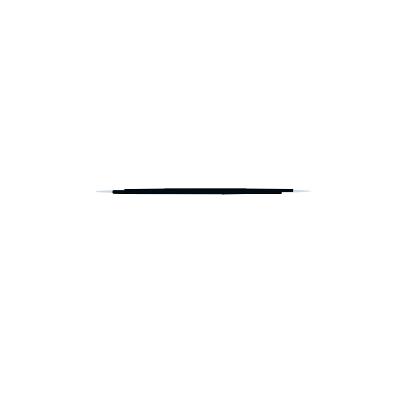

z


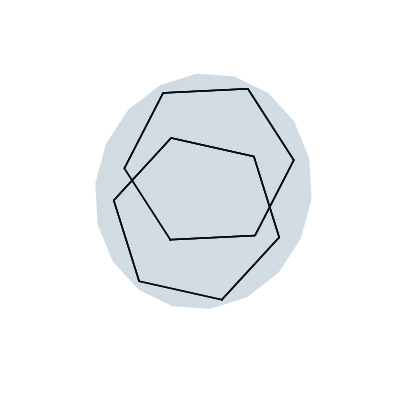

x


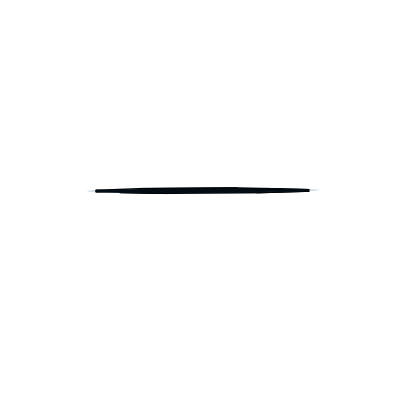

y


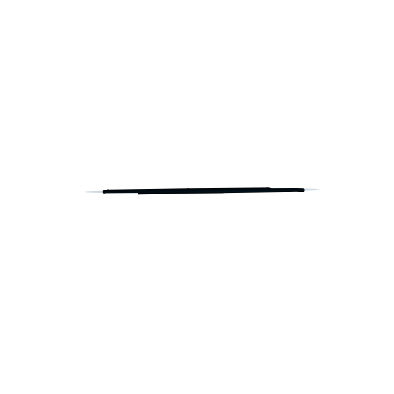

z


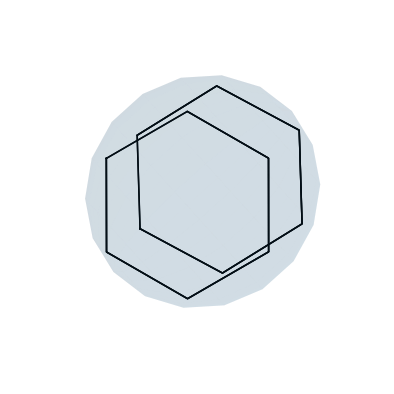

x


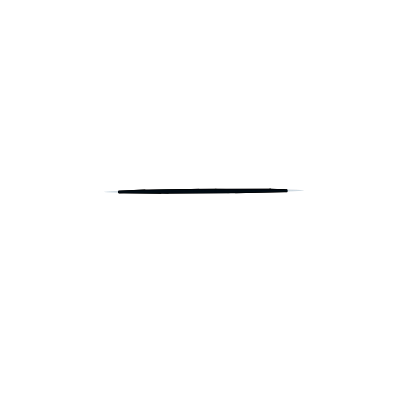

y


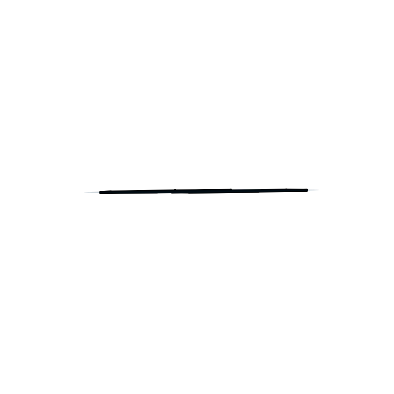

z


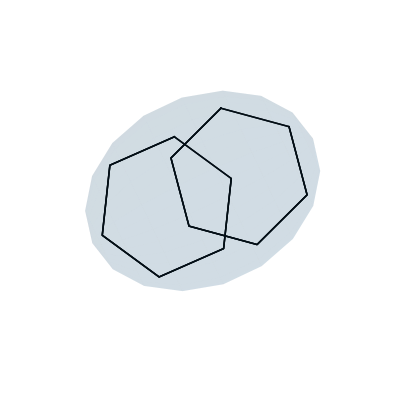

x


KeyboardInterrupt: 

In [5]:
if __name__ == '__main__':
    phioarr=np.logspace(-1.5, 2, num=20, dtype=None)#just columns (0,2); plates (-2,0)
    phioarr = [.01]
    #reqarr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
    reqarr = [10] 
    nclusters = 300         #changes how many aggregates per aspect ratio to consider
    ncrystals = 2
    rand_orient = False      #randomly orient the seed crystal and new crystal: uses first random orientation

    output = main()
    agg_as, agg_bs, agg_cs = compute()

In [ ]:
# save results to file
results = {'agg_as': agg_as, 'agg_bs':agg_bs, 'agg_cs':agg_cs}
filename = '../instance_files/instance_iceice_flat_r10_phi20_run5'
filehandler = open(filename, 'wb')
pickle.dump(results, filehandler)
filehandler.close()
print('finished!')